<a href="https://colab.research.google.com/github/GVSU-CIS635/term-project-proposal-data_minds/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

## Context Summary

The dataset represents credit card transactions made by European cardholders over two days in September 2013. Out of 284,807 transactions, 492 are fraudulent, making this a highly imbalanced dataset with the positive class (fraud) representing only 0.172% of the total. The features have been anonymized using Principal Component Analysis (PCA) to protect confidentiality, except for the `Time` and `Amount` columns.

### Key Features

1. **Time**:
    
    - Measures the seconds elapsed from the first transaction in the dataset.
    - Can help identify patterns such as the frequency of transactions over time, which may be useful in fraud detection (e.g., unusually rapid transactions could indicate fraud).
2. **V1, V2, ..., V28**:
    
    - These are PCA-transformed features. Each component captures a combination of characteristics from the original transaction data that contribute most to variance.
    - Due to the transformation, they don’t have direct interpretations, but the model can still learn patterns from these features.
3. **Amount**:
    
    - Represents the monetary value of the transaction.
    - Can be used for cost-sensitive learning; larger transaction amounts could be a red flag when associated with other suspicious behaviors.
4. **Class**:
    
    - The target variable:
        - **0**: Legitimate transaction.
        - **1**: Fraudulent transaction.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
%matplotlib inline
from matplotlib.pylab import rcParams
import zipfile
from io import BytesIO
import requests

## Section 1: Implementation Plan

Let's explore the data.

In [ ]:
# Download the zip file from the URL
url = 'https://github.com/GVSU-CIS635/Datasets/blob/master/creditcard.csv.zip?raw=true'
response = requests.get(url)

# Define the new column names
new_column_names = []

# Rename the PCA-transformed features (V1 to V28) dynamically
for i in range(1, 29):
    new_column_names.append(f"V{i}")

# Rename the columns in the dataset
new_column_names = ["Time"] + new_column_names + ["Amount", "Class"]

# Open the zip file from the downloaded content
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    # Choose the file within the zip (e.g., 'data.csv')
    file_name = 'creditcard.csv'  # Replace with the name of the CSV file inside the zip

    # Read the CSV file directly from the zip archive
    with zip_ref.open(file_name) as file:
        data = pd.read_csv(file, names=new_column_names)

# Display basic information about the dataset and the first few rows to understand its structure
data_info = data.info()
data_head = data.head()

display(data_info)
display(data_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Step 1: Data Cleaning and Preprocessing

- **Handle Missing Values**: Check for any missing values to maintain data quality and ensure model training isn't disrupted by null values.

In [ ]:
# Check for missing values
print("Missing values in the dataset:\n", data.isnull().sum().sum())

Missing values in the dataset:
 0


- **Scale "Amount" Feature**: The 'Amount' feature might have values that differ significantly in scale compared to other features. Scaling ensures uniformity and prevents large values from disproportionately impacting the model's learning.

In [ ]:
# Scale the 'Amount' feature
scaler = StandardScaler()
data['Amount_Scaled'] = scaler.fit_transform(data[['Amount']])

- **Analyze the Distribution of "Time"**: Visualize the distribution of the 'Time' feature to understand transaction patterns that could affect model training.
  - From the output, we can deduce that:
    - The correlation between "Time" and "Class" (fraud label) is approximately -0.012, which is very close to zero. This indicates a negligible relationship between the transaction time and the likelihood of fraud.
    - The "Time" has very low correlation with "Class" fraud attribute, indicating it may have limited predictive value for fraud detection on its own. However, it could still contribute to the model in combination with other features.

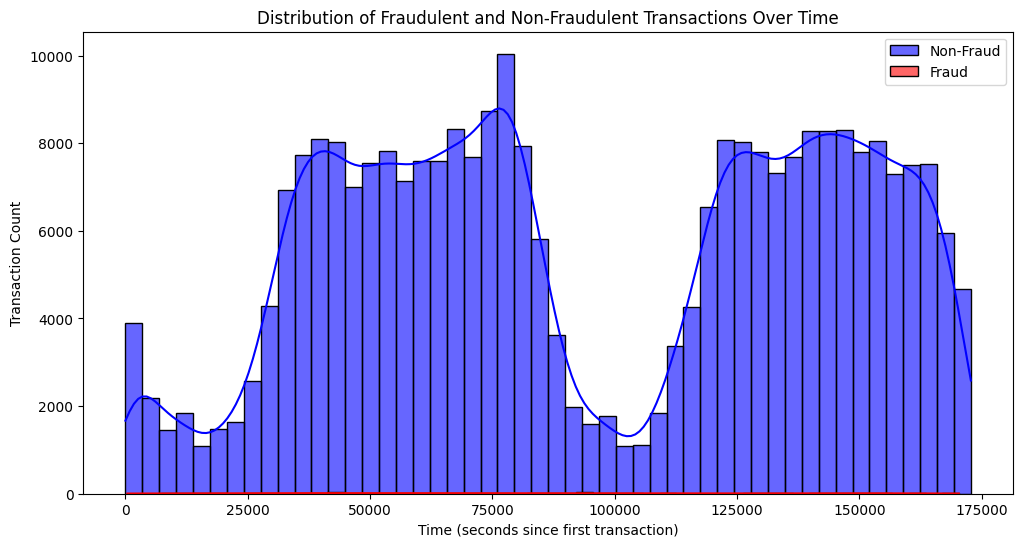

Correlation between Time and Class: -0.0123


In [ ]:
# Plotting distribution of fraudulent and non-fraudulent transactions over time
plt.figure(figsize=(12, 6))

# Plot non-fraudulent transactions over time
sns.histplot(data[data['Class'] == 0]['Time'], bins=50, color='blue', label='Non-Fraud', kde=True, alpha=0.6)

# Plot fraudulent transactions over time
sns.histplot(data[data['Class'] == 1]['Time'], bins=50, color='red', label='Fraud', kde=True, alpha=0.6)

# Plot styling
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions Over Time')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Transaction Count')
plt.legend()
plt.show()

# Calculate correlation between 'Time' and 'Class' to quantify the relationship
correlation_time_fraud = data[['Time', 'Class']].corr().iloc[0, 1]
print(f'Correlation between Time and Class: {correlation_time_fraud:.4f}')

- **Separate Features and Target**:
  - Split the data into features (X) and the target variable (y) to prepare for model training. The target variable ('0.1') indicates whether a transaction is fraudulent (1) or not (0).
  - Create a copy of the dataset before dropping columns to preserve the original data for future use.

In [ ]:
# Drop the original 'Amount' column from the copied DataFrame, since we only need the 'Amount_Scaled' column
data = data.drop(['Amount'], axis=1)

# Prepare features (X) and target (y)
X = data.drop(['Class'], axis=1)  # Features
y = data['Class']  # Target

- **Resampling Using SMOTE**:

  - The dataset is highly imbalanced, with many more legitimate transactions than fraudulent ones.
  - To address this, SMOTE is applied to the training data only to create synthetic samples of the minority class, balancing the training set and improving the model's ability to learn patterns for fraud detection.
  - The test set remains untouched to ensure realistic and unbiased evaluation of the model's performance on data with its original class distribution.

Class distribution before SMOTE:
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution after SMOTE:
Class
0    199008
1    199008
Name: count, dtype: int64


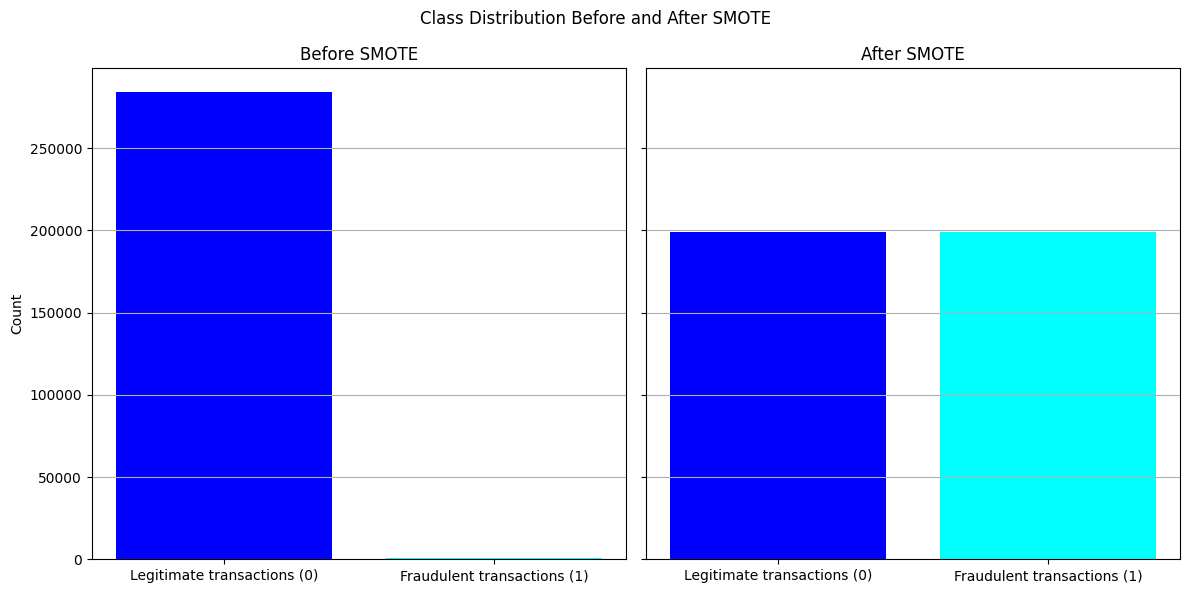

In [ ]:
# Print class counts before SMOTE for clarity
print("Class distribution before SMOTE:")
print(y.value_counts())

# Split the resampled data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE only to the training data to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class counts after SMOTE for clarity
print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

# Check original class distribution
original_class_counts = y.value_counts()

# Check new class distribution after SMOTE
resampled_class_counts = pd.Series(y_train_resampled).value_counts()

# Define consistent colors for classes
class_colors = {0: 'blue', 1: 'cyan'}

# Plot class distributions before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before SMOTE
axes[0].bar(original_class_counts.index, original_class_counts.values, color=[class_colors[cls] for cls in original_class_counts.index])
axes[0].set_title('Before SMOTE')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Legitimate transactions (0)', 'Fraudulent transactions (1)'])
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')

# After SMOTE
axes[1].bar(resampled_class_counts.index, resampled_class_counts.values, color=[class_colors[cls] for cls in resampled_class_counts.index])
axes[1].set_title('After SMOTE')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Legitimate transactions (0)', 'Fraudulent transactions (1)'])
axes[1].grid(axis='y')

plt.suptitle('Class Distribution Before and After SMOTE')
plt.tight_layout()
plt.show()

### Step 2: Model Development

- **Training Models**:
  - Splitting the dataset into training and testing sets allows us to train the model on one portion and evaluate it on another, ensuring generalizability and preventing overfitting.
  - Training multiple models ensures we explore different machine learning algorithms to find the most effective one for classifying fraudulent transactions.
  - Using cross-validation helps validate the model's performance across different subsets of the data, and GridSearchCV helps fine-tune hyperparameters to optimize model performance.

- **Models Used**:
    
    - **Logistic Regression**: A baseline linear model for binary classification.
    - **Random Forest**: An ensemble of decision trees for better accuracy and robustness.
    - **XGBoost**: A powerful gradient boosting algorithm that often yields high performance.
    - **Neural Network**: A multi-layer perceptron to capture complex patterns in data.

- **Hyperparameter Tuning**:

    - **`GridSearchCV`**: Used for an exhaustive search over the specified parameter grids to find the best hyperparameters.
    - **`StratifiedKFold`**: Ensures each fold in cross-validation has a representative proportion of each class, providing a more reliable performance measure.
    - **Scoring Metric**: The `roc_auc` score is used as the scoring metric, suitable for imbalanced classification tasks.

In [ ]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(max_iter=500, random_state=42)
}

# Define parameter grids for each model to tune hyperparameters
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 10]},
    'Neural Network': {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'activation': ['relu', 'tanh']}
}

# Dictionary to store the best models
best_models = {}

# Train models with cross-validation and GridSearchCV for hyperparameter tuning
for model_name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid[model_name],
        cv=StratifiedKFold(5),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=4
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Logistic Regression: {'C': 10}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Neural Network: {'activation': 'relu', 'hidden_layer_sizes': (100, 50)}


### Step 3: Model Evaluation

- After tuning and selecting the best model parameters in the `best_models` dictionary, we will evaluate each model on the test set:
    - **Classification Report**: Precision, recall, F1-score, and accuracy.
    - **ROC-AUC Score** and **ROC Curve**: Indicates the model's discriminative ability.
    - **Confusion Matrix**: Visualizes true positives, false positives, true negatives, and false negatives, highlighting model accuracy on fraud detection.
    - **AUPRC Score and Precision-Recall Curve**: Especially useful for imbalanced datasets, as it shows the balance between precision and recall.

*************************************************************************************
--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.14      0.93      0.24       136

    accuracy                           0.99     85443
   macro avg       0.57      0.96      0.62     85443
weighted avg       1.00      0.99      0.99     85443

ROC-AUC Score: 0.9825
AUPRC Score: 0.8086


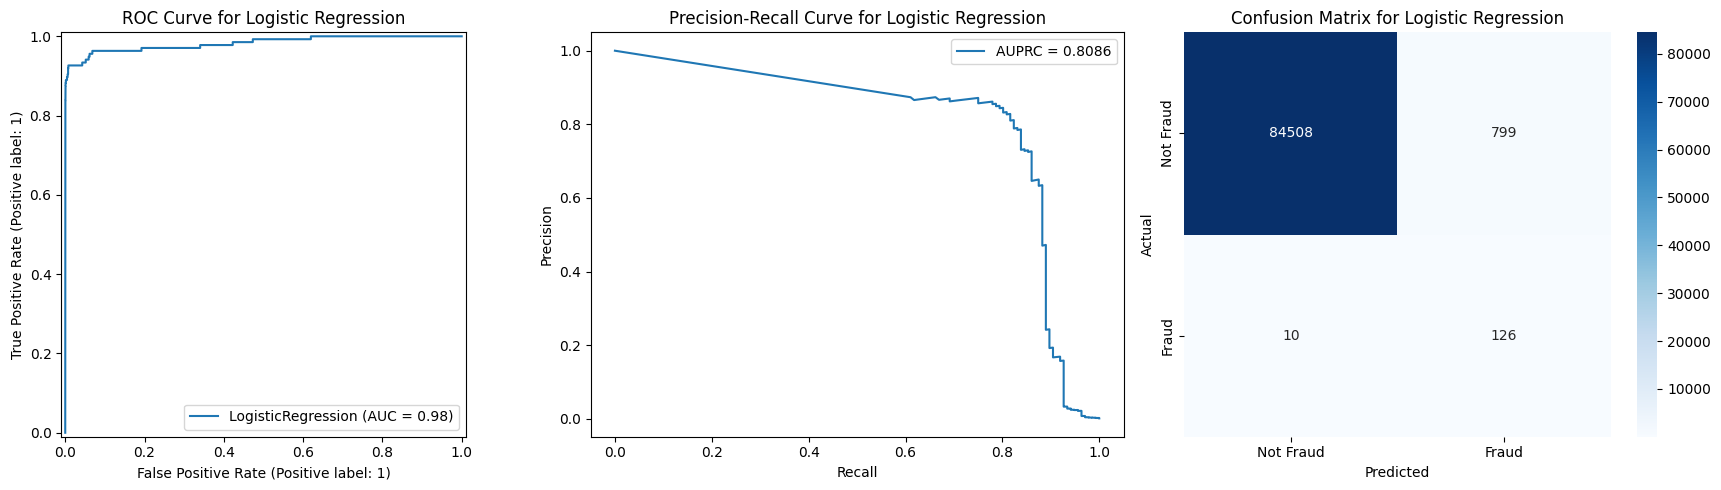

*************************************************************************************
--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.80      0.88      0.84       136

    accuracy                           1.00     85443
   macro avg       0.90      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9900
AUPRC Score: 0.8810


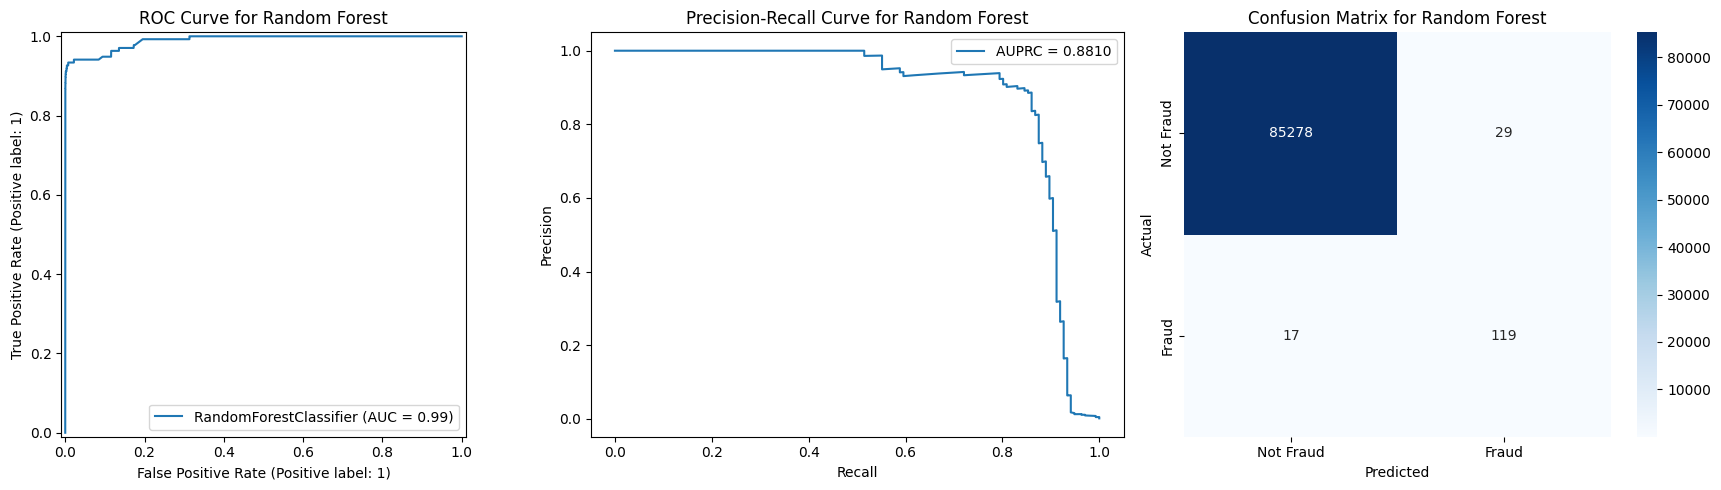

*************************************************************************************
--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.78      0.86      0.82       136

    accuracy                           1.00     85443
   macro avg       0.89      0.93      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9911
AUPRC Score: 0.8858


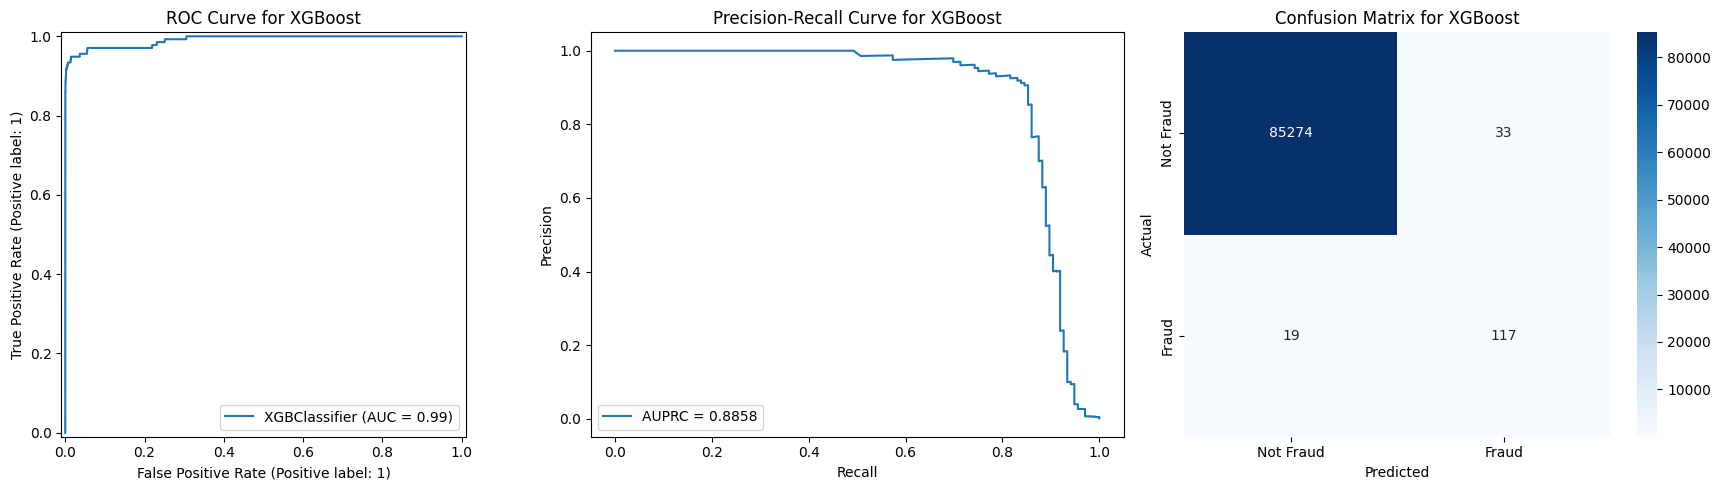

*************************************************************************************
--- Neural Network Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.18      0.90      0.30       136

    accuracy                           0.99     85443
   macro avg       0.59      0.95      0.65     85443
weighted avg       1.00      0.99      1.00     85443

ROC-AUC Score: 0.9684
AUPRC Score: 0.8243


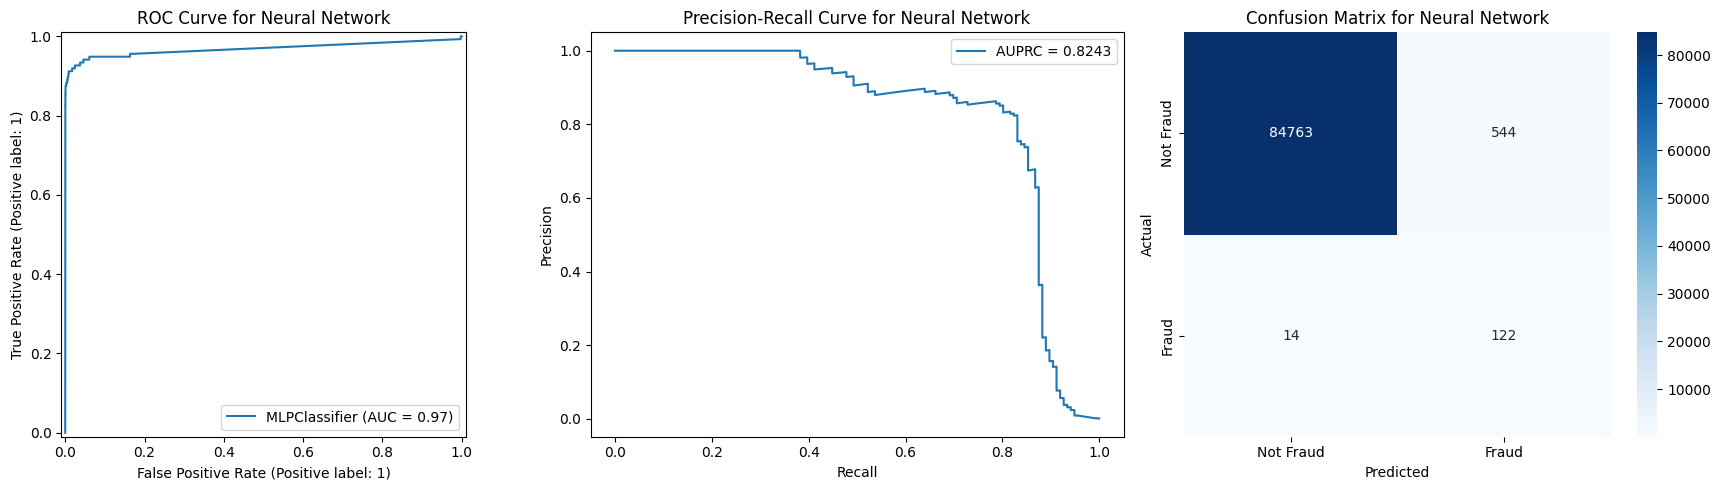

In [ ]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, model_name):
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Print classification report
    print('*************************************************************************************')
    print(f"--- {model_name} Evaluation ---")
    print(classification_report(y_test, y_pred))

    # Start a figure with three subplots for ROC curve, Precision-Recall curve, and Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot ROC Curve if probabilities are available
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

        # Plot ROC curve
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
        axes[0].set_title(f'ROC Curve for {model_name}')

        # Calculate and plot Precision-Recall Curve for AUPRC if probabilities are available
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auprc = auc(recall, precision)
        print(f"AUPRC Score: {auprc:.4f}")

        # Plot Precision-Recall Curve
        axes[1].plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title(f'Precision-Recall Curve for {model_name}')
        axes[1].legend(loc='best')

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                ax=axes[2])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].set_title(f'Confusion Matrix for {model_name}')

    plt.tight_layout()
    plt.show()

# Evaluate each model in best_models on the test set
for model_name, model in best_models.items():
    evaluate_model(model, X_test, y_test, model_name)


### Step 4: Ensemble Learning

- `Random Forest` and `XGBoost` are retrieved from the `best_models` dictionary and used to create the `VotingClassifier`.
- We use **soft voting** to combine the models, where the Voting Classifier averages the predicted probabilities from both `Random Forest` and `XGBoost`. This approach can often lead to more balanced and robust predictions.
- We use the `evaluate_model` function to assess the ensemble model's performance, displaying:
    - **Classification Report**: Precision, recall, F1-score, and accuracy.
    - **ROC-AUC Score** and **ROC Curve**: Indicates the model's discriminative ability.
    - **Confusion Matrix**: Visualizes true positives, false positives, true negatives, and false negatives, highlighting model accuracy on fraud detection.
    - **AUPRC Score and Precision-Recall Curve**: Especially useful for imbalanced datasets, as it shows the balance between precision and recall.

*************************************************************************************
--- Voting Classifier (Random Forest + XGBoost) Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.80      0.87      0.83       136

    accuracy                           1.00     85443
   macro avg       0.90      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9912
AUPRC Score: 0.8812


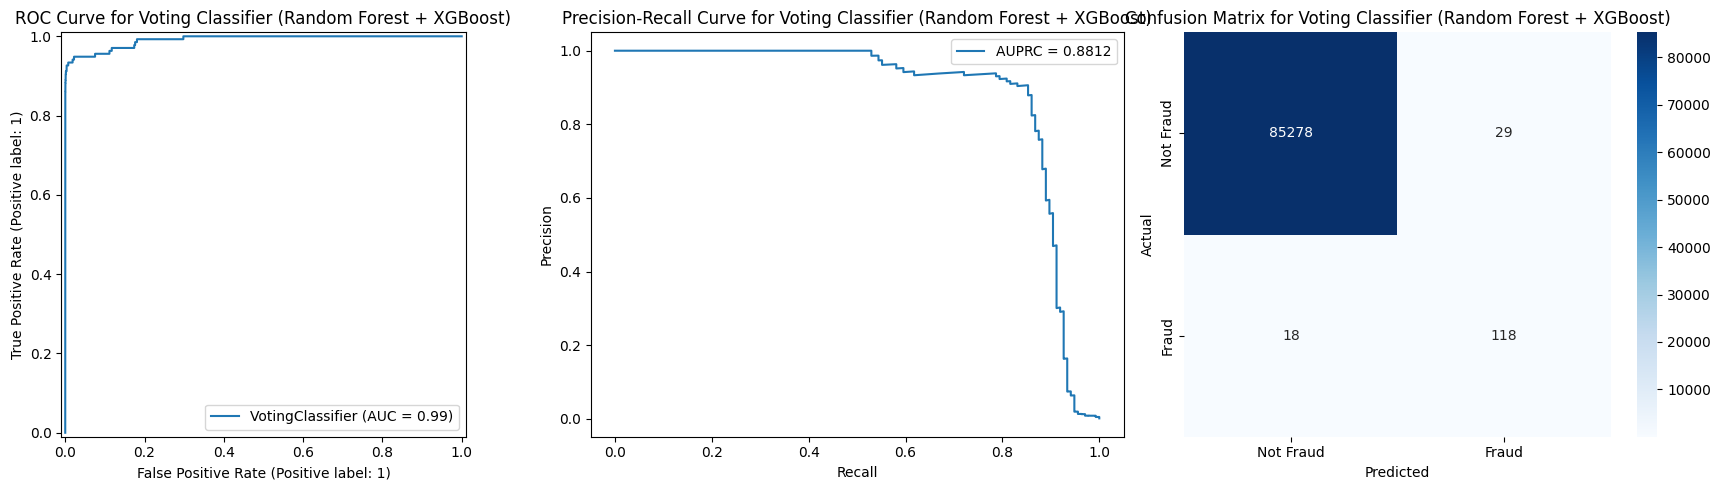

In [ ]:
# Access the saved models from the best_models dictionary
random_forest = best_models['Random Forest']
xgboost = best_models['XGBoost']

# Create the Voting Classifier using the saved models with Soft Voting
voting_clf = VotingClassifier(
    estimators=[('Random Forest', random_forest), ('XGBoost', xgboost)],
    voting='soft'  # Soft voting uses the average of predicted probabilities
)

# Fit the Voting Classifier to the training data (if necessary)
voting_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the Voting Classifier
evaluate_model(voting_clf, X_test, y_test, "Voting Classifier (Random Forest + XGBoost)")

## Section 2: Evaluation Plan

---

### Explanation of Evaluation Metrics

1. **Classification Report**:
   - Provides metrics like **Precision**, **Recall**, and **F1-Score** for each class (Not Fraud and Fraud).
   - These metrics are especially important for fraud detection, where correctly identifying the minority class (Fraud) is crucial.
   - **Precision** indicates the percentage of transactions classified as fraud that are actually fraud, while **Recall** (True Positive Rate) measures the percentage of actual fraud cases that were successfully identified.

2. **AUPRC (Area Under the Precision-Recall Curve)**:
   - **AUPRC** is well-suited for imbalanced datasets because it focuses on the positive (fraud) class.
   - The **Precision-Recall Curve** shows the trade-off between precision and recall at various thresholds, and AUPRC measures the area under this curve.
   - **Interpretation**: A higher AUPRC score indicates that the model maintains high precision and recall simultaneously, which is essential in fraud detection where correctly identifying fraud is crucial.

3. **ROC-AUC Score**:
   - The ROC-AUC score measures the model's ability to distinguish between classes across various thresholds.
   - A higher ROC-AUC score indicates better overall performance in separating fraud from non-fraud, especially helpful in imbalanced datasets.

4. **ROC Curve**:
   - The ROC curve visually shows the trade-off between the **True Positive Rate** (Recall) and **False Positive Rate** across different thresholds.
   - This helps assess the model's separability of classes, which is useful in determining how well it can identify fraud without flagging too many false positives.

5. **Confusion Matrix**:
   - Displays counts of **True Positives** (fraud correctly identified), **False Positives** (non-fraud classified as fraud), **True Negatives** (non-fraud correctly identified), and **False Negatives** (fraud missed).
   - Provides insight into the model's classification accuracy, especially for understanding misclassification patterns.

---

### What to Look For

1. **High Recall for the Fraud Class**:
   - Since this is a fraud detection problem, **high Recall** for the Fraud class is typically more important than overall accuracy. This ensures that most fraudulent transactions are detected.

2. **Balanced Precision and Recall**:
   - A balance between **Precision** and **Recall** (i.e., a high F1-score) for the Fraud class is desirable to minimize both False Negatives and False Positives.

3. **High AUPRC**:
   - A high AUPRC score suggests that the model performs well at both high and low thresholds for fraud detection, balancing precision and recall effectively.

---

### Combined Model Evaluation and Analysis

Each model is evaluated based on **Precision**, **Recall**, **F1-Score**, **AUPRC**, **ROC-AUC**, and **Confusion Matrix**, with a specific focus on identifying fraudulent transactions.

#### **1. Logistic Regression**

**Performance Metrics:**

- **Precision for fraud**: 0.14 - A relatively low precision, indicating a higher proportion of legitimate transactions are misclassified as fraud.
- **Recall for fraud**: 0.93 - The model successfully identifies 93% of fraudulent transactions, minimizing false negatives.
- **F1-Score**: 0.24 - Reflects the balance between precision and recall but is limited due to low precision.
- **ROC-AUC Score**: 0.9825 – A high score indicating good overall discrimination between classes.
- **AUPRC Score**: 0.8086 – A strong balance of precision and recall for identifying fraud.

**Visual Interpretation:**

- **ROC Curve**: Approaches the top-left corner, showing strong sensitivity and specificity.
- **Precision-Recall Curve**: High recall but lower precision due to more false positives.
- **Confusion Matrix**: Indicates excellent fraud detection (high recall) but misclassifies some legitimate transactions as fraud.

**Summary:** Logistic Regression achieves high recall for fraud cases, making it suitable for situations where detecting fraud is critical. However, the low precision could lead to operational challenges from excessive false positives.


#### **2\. Random Forest**

**Performance Metrics:**

- **Precision for fraud**: 0.80 – Indicates most flagged fraudulent transactions are correctly identified.
- **Recall for fraud**: 0.88 – Detects a high percentage of fraudulent transactions with relatively few false negatives.
- **F1-Score**: 0.84 – Reflects strong overall performance with a good balance between precision and recall.
- **ROC-AUC Score**: 0.9900 – Demonstrates excellent discrimination between fraud and non-fraud classes.
- **AUPRC Score**: 0.8810 – A well-balanced score emphasizing reliable fraud detection.

**Visual Interpretation:**

- **ROC Curve**: Approaches the top-left corner, highlighting high sensitivity and specificity.
- **Precision-Recall Curve**: Balanced curve close to the top-right corner, showing strong performance across thresholds.
- **Confusion Matrix**: Few false positives and false negatives, showing robust fraud detection.

**Summary:** Random Forest provides strong, balanced performance for fraud detection, making it a reliable choice. Its high precision and recall suggest fewer operational challenges compared to Logistic Regression.


#### **3\. XGBoost**

**Performance Metrics:**

- **Precision for fraud**: 0.78 – Slightly lower than Random Forest, but still high.
- **Recall for fraud**: 0.86 – Captures a large proportion of fraud cases, though slightly fewer than Random Forest.
- **F1-Score**: 0.82 – A balanced score reflecting strong performance.
- **ROC-AUC Score**: 0.9911 – Marginally better than Random Forest, indicating excellent discrimination.
- **AUPRC Score**: 0.8858 – Strong balance between precision and recall, slightly outperforming Random Forest.

**Visual Interpretation:**

- **ROC Curve**: Near the top-left corner, demonstrating high sensitivity and specificity.
- **Precision-Recall Curve**: Strong curve, balancing precision and recall effectively.
- **Confusion Matrix**: Similar to Random Forest, with minimal misclassifications.

**Summary:** XGBoost offers performance close to Random Forest with marginally better ROC-AUC and AUPRC scores. It is a strong candidate for fraud detection but should be validated further to confirm generalizability.


#### **4\. Neural Network**

**Performance Metrics:**

- **Precision for fraud**: 0.18 – Indicates many false positives.
- **Recall for fraud**: 0.90 – Effectively identifies most fraudulent transactions but with a trade-off in precision.
- **F1-Score**: 0.30 – Reflects a significant gap between precision and recall.
- **ROC-AUC Score**: 0.9684 – Lower than other models, indicating slightly reduced discrimination.
- **AUPRC Score**: 0.8243 – Strong performance but behind Random Forest and XGBoost.

**Visual Interpretation:**

- **ROC Curve**: Close to the top-left but dips slightly due to lower discrimination.
- **Precision-Recall Curve**: Good recall, but precision limitations reduce overall performance.
- **Confusion Matrix**: Indicates effective fraud detection but misclassifies more legitimate transactions.

**Summary:** The Neural Network performs well in identifying fraud (high recall) but struggles with precision, making it less ideal where false positives are costly. Further tuning could improve its balance.



#### **5\. Voting Classifier (Random Forest + XGBoost)**

**Performance Metrics:**

- **Precision for fraud**: 0.80 – Matches Random Forest.
- **Recall for fraud**: 0.87 – A balanced performance, slightly behind Random Forest.
- **F1-Score**: 0.83 – Reflects a well-balanced model.
- **ROC-AUC Score**: 0.9912 – Marginally better than both Random Forest and XGBoost alone.
- **AUPRC Score**: 0.8812 – Comparable to Random Forest and XGBoost, ensuring robust fraud detection.

**Visual Interpretation:**

- **ROC Curve**: Matches or slightly outperforms the individual models.
- **Precision-Recall Curve**: Consistently high, reflecting a balance of precision and recall.
- **Confusion Matrix**: Maintains minimal false positives and negatives, similar to its component models.

**Summary:** The Voting Classifier leverages the strengths of Random Forest and XGBoost, offering balanced and robust performance. It is a strong choice for fraud detection, mitigating individual model weaknesses.

---

### Final Recommendations

1. **Best Model for Fraud Detection**:
    
    - Random Forest and XGBoost offer strong precision, recall, and F1-scores with high AUPRC and ROC-AUC. They are ideal for fraud detection, though their performance should be validated further.
2. **Balanced Choice**:
    
    - Logistic Regression is a simpler, reliable option with high recall and good overall performance. However, its low precision could cause operational challenges.

3. **For High Recall**:
    
    - Neural Network is suitable if recall is the primary focus. However, its low precision makes it less ideal in scenarios where false positives must be minimized.
4. **Ensemble Approach**:
    
    - The Voting Classifier combines the robustness of Random Forest and XGBoost, achieving balanced performance with minimal overfitting risks. It is the most reliable choice for production deployment.

